# A405 final problem

The cells below read in pres (hPa), hght (m), temp (C), dwpt (C) stored as a dataframe
in final_sounding.h5 dataframe 

For each question, insert a cell or cells that answers the question.  You are free to use any code in the github master branch, but double check before you hand in your notebook that it runs on a clean checkout of the
master branch (i.e. that you've included all your own code).

Hand in via email  (which may not work if the attachment is too big), or by sharing a dropbox-like url.

Due on Wednesday, April 20 at 9am.

Good luck, and don't hesitate to ask if anything is unclear.


In [17]:
import numpy as np
import pandas as pd
import pandas
from matplotlib import pyplot as plt
plt.style.use('ggplot')
from importlib import reload
reload(pd)
reload(pandas)
import h5py
import soundings
from pathlib import Path
from a405thermo.thermlib import find_thetaet, find_rsat, tinvert_thetae
from a405thermo.constants import constants as c
site = 'final_sounding.h5'
sounding_file = str(Path(soundings.__path__[0]) / site)
sounding_file
with pd.HDFStore(sounding_file) as store:
    for key in store:
        df_sounding=store[key]

print(df_sounding.head())

    pres   hght  temp  dwpt
0  991.0  172.0  23.2  19.2
1  988.0  198.0  22.8  18.8
2  941.6  610.0  19.0  15.0
3  925.0  762.0  17.6  13.6
4  908.5  914.0  16.3  13.3


# Problem 1

make a 2 column  plot of the temperature and dewpoint as a function height for
the bottom 8000 meters of the sounding

(0.0, 8000.0)

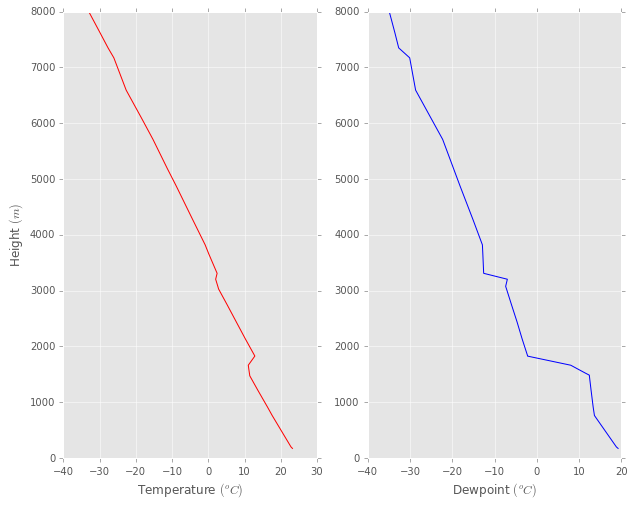

In [68]:
indexes = df_sounding.hght<= 9000.
truncated_df = df_sounding[indexes]

%matplotlib inline

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,8))
ax1.plot(truncated_df.temp, truncated_df.hght, 'r')
ax2.plot(truncated_df.dwpt, truncated_df.hght, 'b')
ax1.set_ylabel('Height $(m)$')
ax1.set_xlabel('Temperature $(^oC)$')
ax2.set_xlabel('Dewpoint $(^oC)$')

ax1.set_ylim(0., 8000.)
ax2.set_ylim(0., 8000.)

# Problem 2

redraw your problem 1 figure, adding the moist adiabat for the lowest point (172 meters) 

In [19]:
from a405thermo.thermlib import find_lcl
from a405thermo.thermlib import find_thetaet

# =========================================================================
# since we know the index of the lowest point, we can specfic the index [0]
# =========================================================================

parcel_data = df_sounding.loc[0]
print(parcel_data)

pres    991.0
hght    172.0
temp     23.2
dwpt     19.2
Name: 0, dtype: float64


In [44]:
# =========================================================================
# functions from here require switching between degC / Kelvin, and hPa / Pa
# =========================================================================
def CtoK(temp):
    return temp + 273.15

def KtoC(temp):
    return temp - 273.15

def hPa_to_Pa(pres):
    return pres * 100.

def Pa_to_hPa(pres):
    return pres / 100.

# =============================================================================================
# find lifting condensation level attributes of parcel, keep parcel data as an 'mini dataframe' 
# never know when package of parcel_data will be useful in future!
# =============================================================================================

parcel_data['lcl_temp'], parcel_data['lcl_pres'] = find_lcl(CtoK(parcel_data.dwpt), CtoK(parcel_data.temp), 
                                                            hPa_to_Pa(parcel_data.pres))

parcel_data.lcl_temp = KtoC(parcel_data.lcl_temp)
parcel_data.lcl_pres = Pa_to_hPa(parcel_data.lcl_pres)

# ==================================================
# Note: at lifting condensation level rv = rT = rsat
# ==================================================

parcel_data['rT'] = find_rsat(CtoK(parcel_data.lcl_temp), hPa_to_Pa(parcel_data.lcl_pres))

# ================================================================================================
# Now we can find the equivalent potential temperaure which will be conserved from the LCL upwards
# ================================================================================================

parcel_data['lcl_thetaet'] = find_thetaet(CtoK(parcel_data.dwpt), parcel_data.rT, CtoK(parcel_data.lcl_temp),
                                          hPa_to_Pa(parcel_data.lcl_pres))

print(parcel_data)

pres           991.000000
hght           172.000000
temp            23.200000
dwpt            19.200000
lcl_temp        18.246981
lcl_pres       933.978646
rT               0.014271
lcl_thetaet    335.660739
Name: 0, dtype: float64


(0.0, 8000.0)

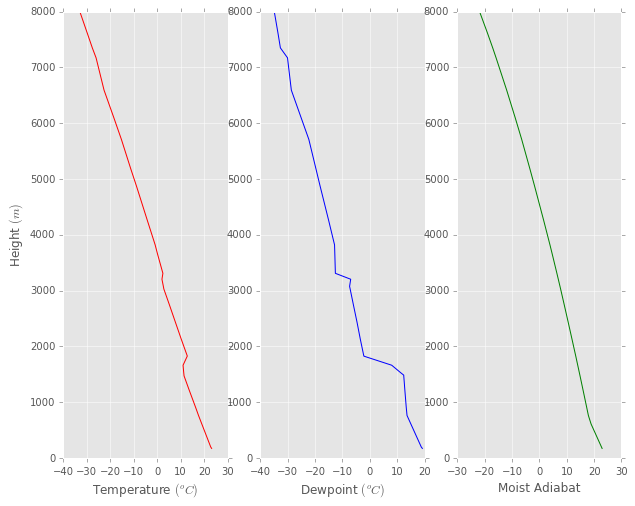

In [101]:
# ===========================================================================
# Producing values for true adiabat, using conservation of entropy
# Entropy calculated at LCL, then adiabat plotted from surface up through LCL
# ===========================================================================

moist_adiabat = []
rv_list = []
rT_list = []

for pres in truncated_df.pres:
    temp, rv, rT = tinvert_thetae(parcel_data.lcl_thetaet, parcel_data.rT, hPa_to_Pa(pres))
    moist_adiabat.append(KtoC(temp))
    rv_list.append(rv)
    rT_list.append(rT)

fig, (ax1,ax2, ax3) = plt.subplots(1,3,figsize=(10,8))
ax1.plot(truncated_df.temp, truncated_df.hght, 'r')
ax2.plot(truncated_df.dwpt, truncated_df.hght, 'b')
ax3.plot(moist_adiabat, truncated_df.hght, 'g')
ax1.set_ylabel('Height $(m)$')
ax1.set_xlabel('Temperature $(^oC)$')
ax2.set_xlabel('Dewpoint $(^oC)$')
ax3.set_xlabel('Moist Adiabat')
ax1.set_ylim(0., 8000.)
ax2.set_ylim(0., 8000.)
ax3.set_ylim(0., 8000.)

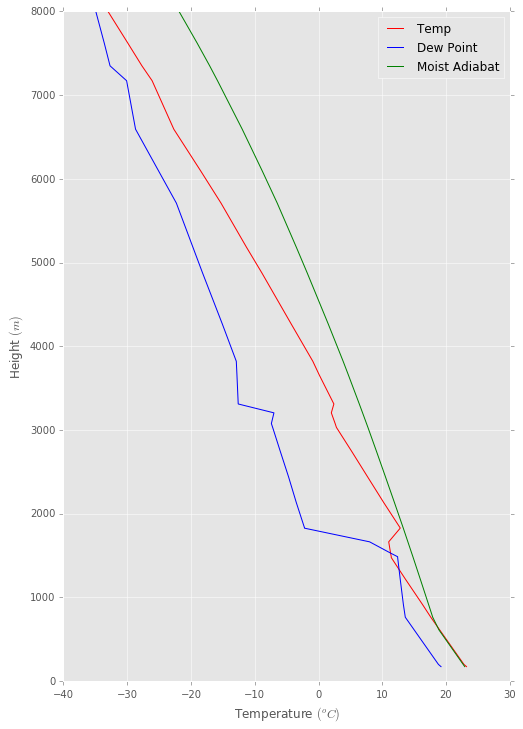

In [100]:
# ====================
# Plotted all together
# ====================

fig1 = plt.figure(figsize=(8,12))
ax1 = fig1.add_subplot(111)
line1 = ax1.plot(truncated_df.temp, truncated_df.hght, 'r', label='Temp')
line2 = ax1.plot(truncated_df.dwpt, truncated_df.hght, 'b', label='Dew Point')
line3 = ax1.plot(moist_adiabat, truncated_df.hght, 'g', label='Moist Adiabat')
ax1.set_ylim(0., 8000.)
ax1.set_xlabel('Temperature $(^oC)$')
ax1.set_ylabel('Height $(m)$')
ax1.legend()

# Problem 3

Write a function that takes as input the dataframe and a height, and finds rv, rl and the buoyancy at that
height.   Use it to calculate rv, rl and the buoyancy for air from 172 meters lifted to 4 km.


# Problem 4

Calculate and make a plot of the virtual temperature of mixtures of adiabatic air from 172 meters and environmental air at 4 km.
Use 20 mixtures evenly spaced between (100% cloud, 0% environment) and (0 %cloud, 100% environment).
Plot the mixing fraction on the x axis and the virtual temperature on the y axis.